vtensorflow core implementation** of [mriberodiaz/federatedRecsys](https://github.com/mriberodiaz/federatedRecsys/blob/master/utilsMovie.py)

In [6]:
from src.data_examples.ex2_data_loader import ExampleDataLoader

import pandas as pd
import tensorflow as tf
import numpy as np

In [7]:
def split_dataframe(df, frac=.8, seed=None):
  df_train = df.sample(frac=frac, random_state=seed)
  df_test = df.drop(df_train.index)
  return df_train, df_test

In [8]:
RAND_SEED = 1337

In [9]:
data_loader = ExampleDataLoader()
data_loader.download().load().clean()

using cached file cache\datasets\movielens\ml-100k.zip
extracting zip file content:
file already exists: data\ex2\ml-100k
file already exists: data\ex2\ml-100k\allbut.pl
file already exists: data\ex2\ml-100k\mku.sh
file already exists: data\ex2\ml-100k\README
file already exists: data\ex2\ml-100k\u.data
file already exists: data\ex2\ml-100k\u.genre
file already exists: data\ex2\ml-100k\u.info
file already exists: data\ex2\ml-100k\u.item
file already exists: data\ex2\ml-100k\u.occupation
file already exists: data\ex2\ml-100k\u.user
file already exists: data\ex2\ml-100k\u1.base
file already exists: data\ex2\ml-100k\u1.test
file already exists: data\ex2\ml-100k\u2.base
file already exists: data\ex2\ml-100k\u2.test
file already exists: data\ex2\ml-100k\u3.base
file already exists: data\ex2\ml-100k\u3.test
file already exists: data\ex2\ml-100k\u4.base
file already exists: data\ex2\ml-100k\u4.test
file already exists: data\ex2\ml-100k\u5.base
file already exists: data\ex2\ml-100k\u5.test
fil

c:\Python310\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Both a converter and dtype were specified for column user_id - only the converter will be used.
  return func(*args, **kwargs)
c:\Python310\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Both a converter and dtype were specified for column user_id - only the converter will be used.
  return func(*args, **kwargs)
c:\Python310\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Both a converter and dtype were specified for column movie_id - only the converter will be used.
  return func(*args, **kwargs)
c:\Python310\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Both a converter and dtype were specified for column movie_id - only the converter will be used.
  return func(*args, **kwargs)
c:\Python310\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Both a converter and dtype were specified for column release_date - only the converter will be used.

In [10]:
features_X = ['user_id', 'movie_id']
feature_Y = 'rating'

df_main = data_loader.df[features_X + [feature_Y]]

for feature in features_X:
  df_main.loc[:, feature] = df_main[feature].astype('int64')

df_main.loc[:, feature_Y] = df_main[feature_Y].astype('float64')


df_train, df_test = split_dataframe(df_main, seed=RAND_SEED)
df_train, df_val = split_dataframe(df_train, seed=RAND_SEED)

train_x, train_y  = df_train[features_X].values, df_train[feature_Y].values
val_x,   val_y    = df_val[features_X].values,   df_val[feature_Y].values


C:\Users\62896\AppData\Local\Temp\ipykernel_29904\2420723086.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_main.loc[:, feature] = df_main[feature].astype('int64')
C:\Users\62896\AppData\Local\Temp\ipykernel_29904\2420723086.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_main.loc[:, feature_Y] = df_main[feature_Y].astype('float64')


## Contralized Model

### Collaborative Filtering Model

In [11]:
class CollaborativeFilteringModel(tf.keras.Model):
  def __init__(self, n_U, n_V, embedding_size, **kwargs):
    super().__init__(**kwargs)
    self._num_U = n_U
    self._num_V = n_V
    self._embedding_size = embedding_size

    self.embedding_U = tf.keras.layers.Embedding(
      n_U,
      embedding_size,
      embeddings_initializer='he_normal',
      embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
    )
    self.bias_U = tf.keras.layers.Embedding(n_U, 1)

    self.embedding_V = tf.keras.layers.Embedding(
      n_V,
      embedding_size,
      embeddings_initializer='he_normal',
      embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
    )
    self.bias_V = tf.keras.layers.Embedding(n_V, 1)


  def call(self, inputs):
    vec_U = self.embedding_U(inputs[:, 0])
    bias_U = self.bias_U(inputs[:, 0])
    vec_V = self.embedding_V(inputs[:, 1])
    bias_V = self.bias_V(inputs[:, 1])

    dot_U_V = tf.tensordot(vec_U, vec_V, 2)
    x = dot_U_V + bias_U + bias_V

    return tf.nn.sigmoid(x)



In [12]:
embedding_size = 30
n_epoch = 10

In [13]:
count_users = len(data_loader.get_feature_values('user_id', tb_name='users'))
count_movies = len(data_loader.get_feature_values('movie_id', tb_name='movies'))

model = CollaborativeFilteringModel(count_users, count_movies, embedding_size)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
)


In [14]:
history = model.fit(
    x=train_x,
    y=train_y,
    batch_size=30,
    epochs=n_epoch,
    verbose=1,
    validation_data=(val_x, val_y),
)


Epoch 1/10
2134/2134 [==============================] - 3s 1ms/step - loss: 0.6263 - val_loss: 0.6011
Epoch 2/10
2134/2134 [==============================] - 2s 1ms/step - loss: 0.5937 - val_loss: 0.5930
Epoch 3/10
2134/2134 [==============================] - 2s 1ms/step - loss: 0.5861 - val_loss: 0.5892
Epoch 4/10
2134/2134 [==============================] - 2s 1ms/step - loss: 0.5825 - val_loss: 0.5874
Epoch 5/10
2134/2134 [==============================] - 2s 1ms/step - loss: 0.5802 - val_loss: 0.5853
Epoch 6/10
2134/2134 [==============================] - 2s 1ms/step - loss: 0.5782 - val_loss: 0.5847
Epoch 7/10
2134/2134 [==============================] - 2s 1ms/step - loss: 0.5772 - val_loss: 0.5844
Epoch 8/10
2134/2134 [==============================] - 2s 1ms/step - loss: 0.5758 - val_loss: 0.5833
Epoch 9/10
2134/2134 [==============================] - 2s 1ms/step - loss: 0.5753 - val_loss: 0.5835
Epoch 10/10
2134/2134 [==============================] - 2s 1ms/step - loss: 0.574

In [15]:
model.summary()

Model: "collaborative_filtering_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  28290     
                                                                 
 embedding_1 (Embedding)     multiple                  943       
                                                                 
 embedding_2 (Embedding)     multiple                  50460     
                                                                 
 embedding_3 (Embedding)     multiple                  1682      
                                                                 
Total params: 81,375
Trainable params: 81,375
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.get_weights()

[array([[-0.00462558, -0.05966859, -0.12080443, ...,  0.11570204,
          0.02336305,  0.00651693],
        [ 0.0516712 , -0.1528795 , -0.07260893, ...,  0.02444115,
         -0.14260642, -0.05060657],
        [-0.32087526,  0.01944581, -0.02934275, ...,  0.03422111,
          0.00133017, -0.07161213],
        ...,
        [ 0.12658212, -0.11557602, -0.06127989, ..., -0.20581503,
          0.02952947, -0.09850264],
        [ 0.00685458, -0.09362075,  0.0953987 , ...,  0.04534001,
          0.00144384,  0.09983504],
        [-0.09699056, -0.07302397,  0.08605804, ..., -0.12857229,
         -0.1953682 ,  0.09740227]], dtype=float32),
 array([[ 6.85720220e-02],
        [ 1.06847137e-01],
        [-3.59977961e-01],
        [ 6.06667280e-01],
        [-7.96708405e-01],
        [-2.26087868e-01],
        [ 3.55707616e-01],
        [ 2.51657903e-01],
        [ 3.52747470e-01],
        [ 2.84922808e-01],
        [-7.72027299e-02],
        [ 4.21721578e-01],
        [-4.53810692e-01],
       

In [17]:
import matplotlib.pyplot as plt

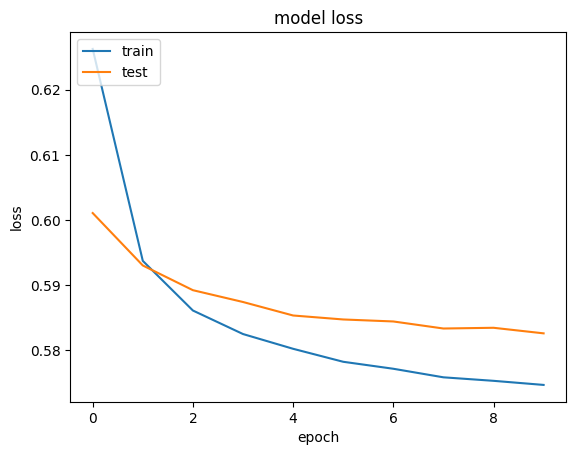

In [18]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()